In [1]:
import pandas as pd
from numpy import mean
from scipy import stats #scipy란 과학기술 통계분석함수 모음이다.
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['axes.unicode_minus'] = False
import mglearn 
import missingno as msno
import seaborn as sns
from keras.optimizers import RMSprop
from keras.models import Sequential,load_model
from keras.layers import Dense, Activation,LSTM,Dropout
from keras import layers
from keras.optimizers import RMSprop
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import keras
from mpl_toolkits.mplot3d import Axes3D
from keras import models
from keras.utils import np_utils
from numpy import argmax



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


Using TensorFlow backend.


In [2]:
#당진 AWS 기상데이터(기온/습도)를 받아온다.
weather_df=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/gogo/weather_df.csv')                       

In [3]:
weather_df

,Unnamed: 0,일시,기온(°C),습도(%)
0,0,2016-01-01 0:01,-0.3,87.5
1,1,2016-01-01 0:02,-0.3,87.5
2,2,2016-01-01 0:03,-0.3,87.6
3,3,2016-01-01 0:04,-0.4,87.6
4,4,2016-01-01 0:05,-0.4,87.5
...,...,...,...,...
2090471,518740,2019-12-31 23:56,-6.3,77.8
2090472,518741,2019-12-31 23:57,-6.3,77.9
2090473,518742,2019-12-31 23:58,-6.3,77.7
2090474,518743,2019-12-31 23:59,-6.4,78.0


In [4]:
#plant1의 데이터를 가져온다.
plant1_train=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_traincp.csv')
plant_test = pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant_testcp.csv')


In [5]:
#파일 호출시 unnamed 0 제거방법은 read_csv('*.csv',index_col=[0])를 해줘도 된다.
weather_df=weather_df.iloc[0:,1:]
plant1_train=plant1_train.iloc[0:,1:]
plant_test=plant_test.iloc[0:,1:]

In [6]:
weather_df

,일시,기온(°C),습도(%)
0,2016-01-01 0:01,-0.3,87.5
1,2016-01-01 0:02,-0.3,87.5
2,2016-01-01 0:03,-0.3,87.6
3,2016-01-01 0:04,-0.4,87.6
4,2016-01-01 0:05,-0.4,87.5
...,...,...,...
2090471,2019-12-31 23:56,-6.3,77.8
2090472,2019-12-31 23:57,-6.3,77.9
2090473,2019-12-31 23:58,-6.3,77.7
2090474,2019-12-31 23:59,-6.4,78.0


In [7]:
#다운 받을때 컬럼에 해당 파일명이 추가 된것 같다. 삭제해주자
plant1_train.columns=plant1_train.columns.str.replace('plant1_train.','')

In [8]:
#plant1_train의 mea_ddhr이 object이므로 datetime으로 변환해준다.
plant1_train['mea_ddhr'] = pd.to_datetime(plant1_train['mea_ddhr'], format='%Y-%m-%d %H:%M:%S', errors='raise')

#마찬가지로 '일시'도 datetime으로 변환
weather_df['일시'] = pd.to_datetime(weather_df['일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [9]:
plant1_train=plant1_train.rename(columns={'mea_ddhr':'일시'})



In [10]:
#결측치를 제거한다.
plant1_train.isna().sum()
plant1_train=plant1_train.dropna(axis=0)
plant1_train.shape

(57854, 15)

In [11]:
weather_df[weather_df['기온(°C)']==np.NaN]

,일시,기온(°C),습도(%)


In [12]:
weather_df=weather_df.dropna(axis=0)
weather_df

,일시,기온(°C),습도(%)
0,2016-01-01 00:01:00,-0.3,87.5
1,2016-01-01 00:02:00,-0.3,87.5
2,2016-01-01 00:03:00,-0.3,87.6
3,2016-01-01 00:04:00,-0.4,87.6
4,2016-01-01 00:05:00,-0.4,87.5
...,...,...,...
2090471,2019-12-31 23:56:00,-6.3,77.8
2090472,2019-12-31 23:57:00,-6.3,77.9
2090473,2019-12-31 23:58:00,-6.3,77.7
2090474,2019-12-31 23:59:00,-6.4,78.0


In [13]:
# weather_df의 자료를 plant1_train에 추가 해줄것이다.
# weahter_df은 분당 자료이므로 plant1_train의 'mea_ddhr'의 시간과 동일한 데이터만 추가해줄것
df_plant1=pd.merge(weather_df, plant1_train, on='일시')


In [14]:
df_plant1=df_plant1.dropna(axis=0)
df_plant1.isna().sum()
#결측치 제거 및 '일시'와 'mea_ddhr'이 동일한 값들만 남았다.
df_plant1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57655 entries, 0 to 57654
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   일시             57655 non-null  datetime64[ns]
 1   기온(°C)         57655 non-null  float64       
 2   습도(%)          57655 non-null  float64       
 3   tem_in_loc1    57655 non-null  float64       
 4   hum_in_loc1    57655 non-null  float64       
 5   tem_coil_loc1  57655 non-null  float64       
 6   tem_in_loc2    57655 non-null  float64       
 7   hum_in_loc2    57655 non-null  float64       
 8   tem_coil_loc2  57655 non-null  float64       
 9   tem_in_loc3    57655 non-null  float64       
 10  hum_in_loc3    57655 non-null  float64       
 11  tem_coil_loc3  57655 non-null  float64       
 12  tem_out_loc1   57655 non-null  float64       
 13  hum_out_loc1   57655 non-null  float64       
 14  cond_loc1      57655 non-null  float64       
 15  cond_loc2      5765

In [15]:
df_plant1[df_plant1['cond_loc1']==1]

,일시,기온(°C),습도(%),tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_in_loc2,hum_in_loc2,tem_coil_loc2,tem_in_loc3,hum_in_loc3,tem_coil_loc3,tem_out_loc1,hum_out_loc1,cond_loc1,cond_loc2,cond_loc3
92,2016-04-12 12:00:00,16.2,50.9,18.00,78.00,14.00,16.00,84.00,14.00,15.00,87.00,13.00,16.00,42.00,1.0,1.0,1.0
120,2016-04-16 00:00:00,8.9,84.5,17.00,80.00,14.00,16.00,85.00,13.00,15.00,87.00,12.00,11.00,68.00,1.0,1.0,1.0
241,2016-05-01 03:00:00,14.3,45.8,21.00,80.00,18.00,20.00,82.00,20.00,19.00,84.00,19.00,15.00,44.00,1.0,0.0,0.0
257,2016-05-03 03:00:00,17.5,92.3,21.00,80.00,18.00,20.00,82.00,20.00,19.00,84.00,19.00,19.00,79.00,1.0,0.0,0.0
607,2016-06-16 00:00:00,18.8,92.3,24.00,78.00,19.00,23.00,80.00,24.00,23.00,80.00,23.00,22.00,82.00,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49545,2019-02-03 16:00:00,5.6,93.4,9.05,80.34,5.98,8.17,84.62,4.60,7.80,86.51,3.92,6.21,88.16,1.0,1.0,1.0
49546,2019-02-03 16:10:00,5.0,93.4,8.96,79.82,6.05,8.20,83.67,4.76,7.71,85.50,4.07,5.91,87.94,1.0,1.0,1.0
49547,2019-02-03 16:20:00,4.7,93.4,8.87,78.91,5.94,8.02,83.91,4.64,7.68,85.87,3.88,5.73,87.73,1.0,1.0,1.0
49548,2019-02-03 16:30:00,4.6,93.4,8.84,78.21,5.90,7.95,83.91,4.64,7.62,85.04,3.92,5.51,87.76,1.0,1.0,1.0


In [16]:
#이제 기상 정보는 완성되었다. 예측모델을 생성해보자

# 예측하고 싶은거는? -> 온도, 습도 데이터(tem_in_loc,hum_in_loc1)
# 뭘 하고 싶은데? -> 기온(°C),습도(%)에따른 tem_in_loc1, hum_in_loc1,추가로 tem_coil_loc1의 값을 예측해보자
# 왜 예측해야하는데? -> 정답지에 tem_in_loc1,hum_in_loc1의 데이터가 없는걸 보아하니 온도 습도도 예측해야함

In [17]:
# 분석하기전에 각 컬럼이 서로 얼만큼 영향을 주는지 확인해보자
plant1_tem_hum=df_plant1[['일시','기온(°C)','습도(%)','tem_in_loc1','hum_in_loc1','tem_coil_loc1','cond_loc1','tem_out_loc1','hum_out_loc1']]

plant1_tem_hum=plant1_tem_hum.reset_index(drop=True, inplace=False)



In [18]:
plant1_tem_hum

,일시,기온(°C),습도(%),tem_in_loc1,hum_in_loc1,tem_coil_loc1,cond_loc1,tem_out_loc1,hum_out_loc1
일시,,,,,,,,,
2016-04-01 00:00:00,2016-04-01 00:00:00,6.8,41.2,16.00,24.00,11.00,0.0,9.00,42.00
2016-04-01 03:00:00,2016-04-01 03:00:00,5.2,52.1,14.00,28.00,10.00,0.0,7.00,59.00
2016-04-01 06:00:00,2016-04-01 06:00:00,6.8,40.9,13.00,33.00,10.00,0.0,6.00,56.00
2016-04-01 09:00:00,2016-04-01 09:00:00,13.9,28.9,13.00,33.00,10.00,0.0,18.00,30.00
2016-04-01 12:00:00,2016-04-01 12:00:00,20.4,17.7,16.00,28.00,10.00,0.0,18.00,20.00
...,...,...,...,...,...,...,...,...,...
2019-03-31 23:10:00,2019-03-31 23:10:00,3.3,53.4,10.52,36.39,10.52,0.0,6.40,43.86
2019-03-31 23:20:00,2019-03-31 23:20:00,3.0,57.4,10.52,37.09,10.44,0.0,6.34,44.02
2019-03-31 23:30:00,2019-03-31 23:30:00,3.3,59.2,10.43,37.18,10.56,0.0,6.40,43.04


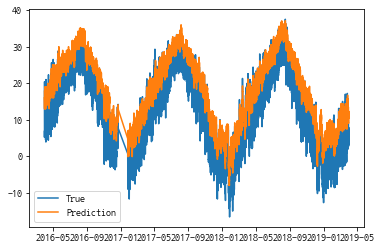

In [19]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(plant1_tem_hum.iloc[:,1], label='True')
ax.plot(plant1_tem_hum.iloc[:,3], label='Prediction')
ax.legend()
plt.show()

#tem_in_loc1과 기상기온의 패턴이 동일하다
#중간의 온도 표시가 잘못된것 같은것의 이유는 모르겠다,노이즈를 주거나 제거하도록
#제거시 iloc[2055:2060]부분만 삭제할것

In [20]:
plant1_tem_hum.shape

(57655, 9)

In [21]:
# # 온도,습도,코일 표면온도와 결로현상의 상관관계 시각화(seaborn 사용)
# sns.pairplot(plant1_tem_hum[['tem_in_loc1','hum_in_loc1','tem_coil_loc1','tem_out_loc1','hum_out_loc1','cond_loc1']], hue="cond_loc1")
# plt.show()

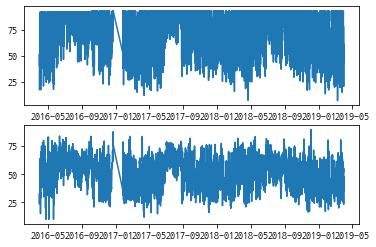

In [22]:
# fig = plt.figure(facecolor='white')
# ax = fig.subplots(111,2)
fig, axes = plt.subplots(nrows=2, ncols=1)

axes[0].plot(plant1_tem_hum.iloc[:,2], label='True')
axes[1].plot(plant1_tem_hum.iloc[:,4], label='Prediction')

plt.show()
#습도는 하위분포는 비슷하지만 기상습도의 90%이상값이 너무 많다.


일시
2017-04-27 10:00:00    32.8
2017-04-29 17:00:00    23.0
Name: 습도(%), dtype: float64

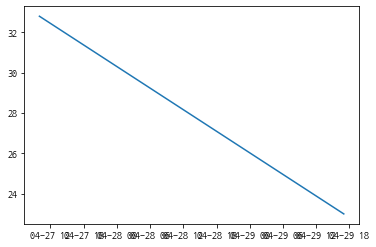

In [23]:
plt.plot(plant1_tem_hum.iloc[4133:4135,2], label='True')


plant1_tem_hum.iloc[4133:4135,2]

In [24]:
plant1_tem_hum

,일시,기온(°C),습도(%),tem_in_loc1,hum_in_loc1,tem_coil_loc1,cond_loc1,tem_out_loc1,hum_out_loc1
일시,,,,,,,,,
2016-04-01 00:00:00,2016-04-01 00:00:00,6.8,41.2,16.00,24.00,11.00,0.0,9.00,42.00
2016-04-01 03:00:00,2016-04-01 03:00:00,5.2,52.1,14.00,28.00,10.00,0.0,7.00,59.00
2016-04-01 06:00:00,2016-04-01 06:00:00,6.8,40.9,13.00,33.00,10.00,0.0,6.00,56.00
2016-04-01 09:00:00,2016-04-01 09:00:00,13.9,28.9,13.00,33.00,10.00,0.0,18.00,30.00
2016-04-01 12:00:00,2016-04-01 12:00:00,20.4,17.7,16.00,28.00,10.00,0.0,18.00,20.00
...,...,...,...,...,...,...,...,...,...
2019-03-31 23:10:00,2019-03-31 23:10:00,3.3,53.4,10.52,36.39,10.52,0.0,6.40,43.86
2019-03-31 23:20:00,2019-03-31 23:20:00,3.0,57.4,10.52,37.09,10.44,0.0,6.34,44.02
2019-03-31 23:30:00,2019-03-31 23:30:00,3.3,59.2,10.43,37.18,10.56,0.0,6.40,43.04


In [25]:
#우선 기상온도, 기상습도로 결로여부를 예측해보자
x_data=np.array(plant1_tem_hum.iloc[:,1:3],dtype=np.float32) #기상온도, 기상습도
y_data=np.array(plant1_tem_hum.iloc[:,6],dtype=np.float32) #cond_loc1

x_data.shape,y_data.shape

((57655, 2), (57655,))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D9A10A5710>],
      dtype=object)

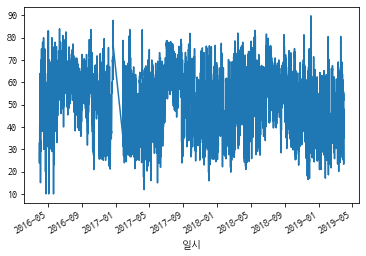

In [26]:
plant1_tem_hum.iloc[:,4].plot(subplots=True)
#습도는 최고지점을 제외하면 거의 비슷하다.

In [27]:
plant1_tem_hum.iloc[:,4]

일시
2016-04-01 00:00:00    24.00
2016-04-01 03:00:00    28.00
2016-04-01 06:00:00    33.00
2016-04-01 09:00:00    33.00
2016-04-01 12:00:00    28.00
                       ...  
2019-03-31 23:10:00    36.39
2019-03-31 23:20:00    37.09
2019-03-31 23:30:00    37.18
2019-03-31 23:40:00    38.00
2019-03-31 23:50:00    38.74
Name: hum_in_loc1, Length: 57655, dtype: float64

In [28]:
plant1_tem_hum=plant1_tem_hum.rename(columns={'기온(°C)':'기상기온'})
plant1_tem_hum=plant1_tem_hum.rename(columns={'습도(%)':'기상습도'})
plant1_tem_hum
# plant1_tem_hum.to_csv('C:/Anaconda3/python/csvdata/hyundae/gogo/전처리완료.csv')

,일시,기상기온,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,cond_loc1,tem_out_loc1,hum_out_loc1
일시,,,,,,,,,
2016-04-01 00:00:00,2016-04-01 00:00:00,6.8,41.2,16.00,24.00,11.00,0.0,9.00,42.00
2016-04-01 03:00:00,2016-04-01 03:00:00,5.2,52.1,14.00,28.00,10.00,0.0,7.00,59.00
2016-04-01 06:00:00,2016-04-01 06:00:00,6.8,40.9,13.00,33.00,10.00,0.0,6.00,56.00
2016-04-01 09:00:00,2016-04-01 09:00:00,13.9,28.9,13.00,33.00,10.00,0.0,18.00,30.00
2016-04-01 12:00:00,2016-04-01 12:00:00,20.4,17.7,16.00,28.00,10.00,0.0,18.00,20.00
...,...,...,...,...,...,...,...,...,...
2019-03-31 23:10:00,2019-03-31 23:10:00,3.3,53.4,10.52,36.39,10.52,0.0,6.40,43.86
2019-03-31 23:20:00,2019-03-31 23:20:00,3.0,57.4,10.52,37.09,10.44,0.0,6.34,44.02
2019-03-31 23:30:00,2019-03-31 23:30:00,3.3,59.2,10.43,37.18,10.56,0.0,6.40,43.04


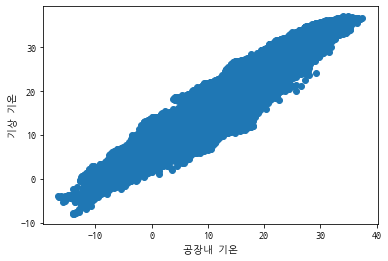

In [29]:
plt.scatter(plant1_tem_hum['기상기온'], plant1_tem_hum['tem_in_loc1'])
plt.xlabel('공장내 기온')
plt.ylabel('기상 기온')
plt.show()
#당연한 거겠지만 기상기온과 공장내 기온은 비례하다고 보면된다, 중간중간 이상치는 습도로인한 이상치로 생각된다.

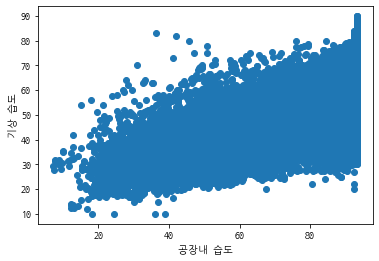

In [30]:
plt.scatter(plant1_tem_hum['기상습도'], plant1_tem_hum['hum_in_loc1'])
plt.xlabel('공장내 습도')
plt.ylabel('기상 습도')
plt.show()

#공장내 습도와 기상습도의 상관관계가 있긴한데 기상습도가 과도한곳이 너무 많다.

# ex) 공장내 습도 90%이상일때도 기상습도가 30%미만인 데이터도 있다.
# 즉, 기상습도로 공장습도를 측정하기는 힘들다.
# 가능은 하겠지만..



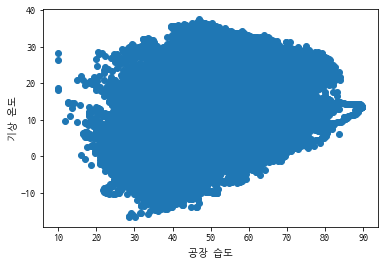

In [31]:
plt.scatter(plant1_tem_hum['hum_in_loc1'],plant1_tem_hum['기상기온'])
plt.xlabel('공장 습도')
plt.ylabel('기상 온도')
plt.show()

# 기상 온도 상승시 습도는 50%에 가까워지고
# 기상 온도가 10~30 사이에서는 습도가 높은 모습을 보인다.


In [32]:
# 데이터 : 기상온도 기상습도
# 예측모델 : 공장내 온도, 공장내 습도
# 딥러닝 : Keras

#그래프 분석결과
#공장내 습도는 v형으로 분류되며 기상기온의 특정 범위에서 습도에 영향을 받는다.
#약간 평준화 그래프 느낌이다.



In [33]:
plant1_tem_hum

,일시,기상기온,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,cond_loc1,tem_out_loc1,hum_out_loc1
일시,,,,,,,,,
2016-04-01 00:00:00,2016-04-01 00:00:00,6.8,41.2,16.00,24.00,11.00,0.0,9.00,42.00
2016-04-01 03:00:00,2016-04-01 03:00:00,5.2,52.1,14.00,28.00,10.00,0.0,7.00,59.00
2016-04-01 06:00:00,2016-04-01 06:00:00,6.8,40.9,13.00,33.00,10.00,0.0,6.00,56.00
2016-04-01 09:00:00,2016-04-01 09:00:00,13.9,28.9,13.00,33.00,10.00,0.0,18.00,30.00
2016-04-01 12:00:00,2016-04-01 12:00:00,20.4,17.7,16.00,28.00,10.00,0.0,18.00,20.00
...,...,...,...,...,...,...,...,...,...
2019-03-31 23:10:00,2019-03-31 23:10:00,3.3,53.4,10.52,36.39,10.52,0.0,6.40,43.86
2019-03-31 23:20:00,2019-03-31 23:20:00,3.0,57.4,10.52,37.09,10.44,0.0,6.34,44.02
2019-03-31 23:30:00,2019-03-31 23:30:00,3.3,59.2,10.43,37.18,10.56,0.0,6.40,43.04


In [34]:
# step1 데이터 설정
# X=온도 습도
# y=공장내 온도, 공장내 습도
# 원하는 예측모델 -> 기상기온, 기상습도를 입력했을때 tem_in_loc1, hum_in_loc1을 예측하고 싶다.

###############################tem_in_loc1과 기온의 범위를 좁히자 소수점 1자리까지만
plant1_tem_hum['tem_in_loc1']=round(plant1_tem_hum['tem_in_loc1'],1)
plant1_data=np.array(plant1_tem_hum.iloc[:,1:])
plant1_tem_hum

,일시,기상기온,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,cond_loc1,tem_out_loc1,hum_out_loc1
일시,,,,,,,,,
2016-04-01 00:00:00,2016-04-01 00:00:00,6.8,41.2,16.0,24.00,11.00,0.0,9.00,42.00
2016-04-01 03:00:00,2016-04-01 03:00:00,5.2,52.1,14.0,28.00,10.00,0.0,7.00,59.00
2016-04-01 06:00:00,2016-04-01 06:00:00,6.8,40.9,13.0,33.00,10.00,0.0,6.00,56.00
2016-04-01 09:00:00,2016-04-01 09:00:00,13.9,28.9,13.0,33.00,10.00,0.0,18.00,30.00
2016-04-01 12:00:00,2016-04-01 12:00:00,20.4,17.7,16.0,28.00,10.00,0.0,18.00,20.00
...,...,...,...,...,...,...,...,...,...
2019-03-31 23:10:00,2019-03-31 23:10:00,3.3,53.4,10.5,36.39,10.52,0.0,6.40,43.86
2019-03-31 23:20:00,2019-03-31 23:20:00,3.0,57.4,10.5,37.09,10.44,0.0,6.34,44.02
2019-03-31 23:30:00,2019-03-31 23:30:00,3.3,59.2,10.4,37.18,10.56,0.0,6.40,43.04


In [35]:
# step1 데이터 설정
# X=온도 습도
# y=공장내 온도, 공장내 습도
# 원하는 예측모델 -> 기상기온, 기상습도를 입력했을때 tem_in_loc1, hum_in_loc1을 예측하고 싶다.



###############################tem_in_loc1과 기온의 범위를 좁히자 소수점 1자리까지만
plant1_tem_hum['tem_in_loc1']=round(plant1_tem_hum['tem_in_loc1'],1)
plant1_data=np.array(plant1_tem_hum[['기상기온','기상습도','cond_loc1']])

In [36]:
plant1_data

array([[ 6.8, 41.2,  0. ],
       [ 5.2, 52.1,  0. ],
       [ 6.8, 40.9,  0. ],
       ...,
       [ 3.3, 59.2,  0. ],
       [ 3.1, 60.1,  0. ],
       [ 2.9, 61.2,  0. ]])

In [37]:
plant1_data=plant1_tem_hum[['기상기온','hum_in_loc1','tem_coil_loc1','cond_loc1']]

In [38]:
plant1_data

,기상기온,hum_in_loc1,tem_coil_loc1,cond_loc1
일시,,,,
2016-04-01 00:00:00,6.8,24.00,11.00,0.0
2016-04-01 03:00:00,5.2,28.00,10.00,0.0
2016-04-01 06:00:00,6.8,33.00,10.00,0.0
2016-04-01 09:00:00,13.9,33.00,10.00,0.0
2016-04-01 12:00:00,20.4,28.00,10.00,0.0
...,...,...,...,...
2019-03-31 23:10:00,3.3,36.39,10.52,0.0
2019-03-31 23:20:00,3.0,37.09,10.44,0.0
2019-03-31 23:30:00,3.3,37.18,10.56,0.0


In [39]:
plant1_tem_hum.to_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_tem_hum.csv')

In [40]:
# plant1_data
x_data=np.array(plant1_data.iloc[:,:3],dtype=np.float32) #기상 온도, 공장습도,코일온도
y_data=np.array(plant1_data.iloc[:,3],dtype=np.float32) #결로여부
X_train, X_test, y_train, y_test =train_test_split(x_data, y_data, random_state=0)

In [41]:
x_data

array([[ 6.8 , 24.  , 11.  ],
       [ 5.2 , 28.  , 10.  ],
       [ 6.8 , 33.  , 10.  ],
       ...,
       [ 3.3 , 37.18, 10.56],
       [ 3.1 , 38.  , 10.56],
       [ 2.9 , 38.74, 10.52]], dtype=float32)

In [42]:
#결로 미발생 데이터가 너무 많으니 발생 데이터와 크기를 맞춰주자
con0data=plant1_tem_hum[plant1_tem_hum['cond_loc1']==0]
con1data=plant1_tem_hum[plant1_tem_hum['cond_loc1']==1]

In [43]:
con0data=con0data.iloc[8000:9000,:]

In [44]:
con0data

,일시,기상기온,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,cond_loc1,tem_out_loc1,hum_out_loc1
일시,,,,,,,,,
2017-10-12 21:00:00,2017-10-12 21:00:00,8.5,93.4,19.0,40.32,19.45,0.0,14.00,52.90
2017-10-12 22:00:00,2017-10-12 22:00:00,8.2,87.4,19.2,39.84,19.56,0.0,13.30,50.58
2017-10-12 23:00:00,2017-10-12 23:00:00,7.2,93.4,19.5,36.60,19.68,0.0,13.08,52.87
2017-10-13 00:00:00,2017-10-13 00:00:00,6.5,93.4,19.3,38.95,19.49,0.0,12.87,54.27
2017-10-13 01:00:00,2017-10-13 01:00:00,6.2,93.4,19.2,38.74,19.56,0.0,12.50,57.17
...,...,...,...,...,...,...,...,...,...
2017-11-23 09:00:00,2017-11-23 09:00:00,-1.2,93.4,6.6,55.68,7.39,0.0,0.42,82.23
2017-11-23 10:00:00,2017-11-23 10:00:00,0.3,93.4,6.5,59.74,7.31,0.0,0.42,84.95
2017-11-23 11:00:00,2017-11-23 11:00:00,1.5,93.4,6.9,60.87,7.24,0.0,2.12,79.85


In [45]:
datanew=pd.concat([con0data, con1data]) 

In [46]:
#미발생 1000건, 발생 275건
#X_train, X_test, y_train, y_test =train_test_split(datanew.iloc[:,1:3],datanew.iloc[:,6], random_state=0)

#미발생 57000건 발생 275건
X_train, X_test, y_train, y_test =train_test_split(x_data,y_data, random_state=0)

In [47]:
model = Sequential()
model.add(Dense(8,input_dim=3, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
                  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                288       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [48]:

hist = model.fit(X_train,y_train,epochs=100,verbose=1,batch_size=512,validation_data=(X_test,y_test)) 

Train on 43241 samples, validate on 14414 samples
Epoch 1/100
43241/43241 [==============================] - 0s 11us/step - loss: 1.5699 - accuracy: 0.7281 - val_loss: 0.0837 - val_accuracy: 0.9945
Epoch 2/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.1861 - accuracy: 0.9651 - val_loss: 0.1066 - val_accuracy: 0.9945
Epoch 3/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.1325 - accuracy: 0.9837 - val_loss: 0.1303 - val_accuracy: 0.9945
Epoch 4/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.1163 - accuracy: 0.9901 - val_loss: 0.1185 - val_accuracy: 0.9945
Epoch 5/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.1117 - accuracy: 0.9900 - val_loss: 0.1073 - val_accuracy: 0.9945
Epoch 6/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.0996 - accuracy: 0.9894 - val_loss: 0.0972 - val_accuracy: 0.9945
Epoch 7/100
43241/43241 [==============================] - 0s 4us/s

43241/43241 [==============================] - 0s 4us/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.0084 - val_accuracy: 0.9962
Epoch 57/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0086 - val_accuracy: 0.9959
Epoch 58/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.0080 - val_accuracy: 0.9967
Epoch 59/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.0095 - accuracy: 0.9970 - val_loss: 0.0073 - val_accuracy: 0.9978
Epoch 60/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0077 - val_accuracy: 0.9969
Epoch 61/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.0108 - val_accuracy: 0.9945
Epoch 62/100
43241/43241 [==============================] - 0s 4us/step - loss: 0.0093 - accuracy: 0.9969 - val_loss: 0.0072 

In [49]:
# sns.pairplot(plant1_tem_hum[['기상기온','기상습도','tem_in_loc1','hum_in_loc1','cond_loc1']], hue="cond_loc1")
# plt.show()

<img src="C:/Anaconda3/python/images/result.png" width="600" height="600">

In [50]:
# step 5. 모델평가
loss_and_metrics = model.evaluate(X_test,y_test,batch_size=32)
print('loss_and_metrics',str(loss_and_metrics))
#손실 0.005%, 정확도 99.45%의 모델이 완성되었다.

14414/14414 [==============================] - 0s 15us/step
loss_and_metrics [0.007258096177494896, 0.9975718259811401]


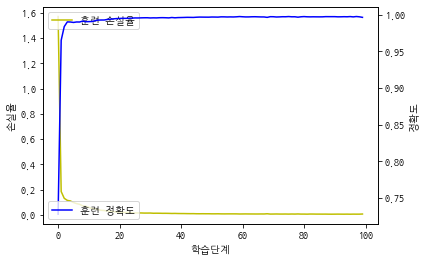

In [51]:
# step7. 모델학습 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='훈련 손실율')
acc_ax.plot(hist.history['accuracy'],'b',label='훈련 정확도')

loss_ax.set_xlabel("학습단계")
loss_ax.set_ylabel("손실율")
acc_ax.set_ylabel("정확도")

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')


plt.show()

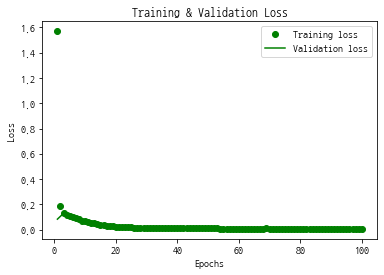

In [52]:
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'go', label='Training loss') #go : green dot
plt.plot(epochs, val_loss, 'g', label='Validation loss') #g : green line
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

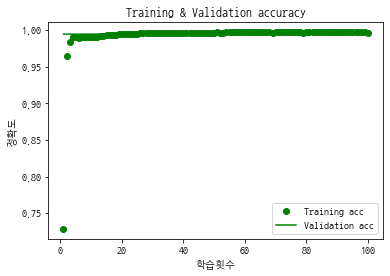

In [53]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'go', label='Training acc') #go : green dot
plt.plot(epochs, val_acc, 'g', label='Validation acc') #g : green line
plt.title('Training & Validation accuracy')
plt.xlabel('학습횟수')
plt.ylabel('정확도')
plt.legend()

plt.show()

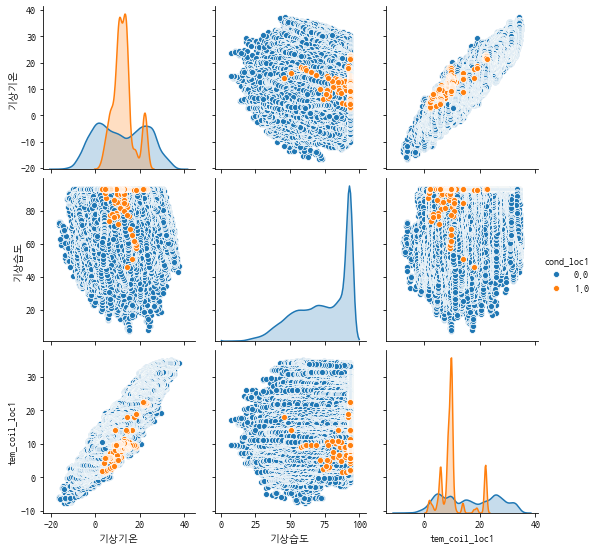

In [54]:
#기상기온과 기상습도로 해도 충분하다.
sns.pairplot(plant1_tem_hum[['기상기온','기상습도','tem_coil_loc1','cond_loc1']], hue="cond_loc1")
plt.show()

In [55]:
#데이터가 문제인게 기상습도가 너무 높다.


In [56]:
X_test.shape

(14414, 3)

In [57]:
sorted(model.predict(X_train),reverse=True)

[array([0.80054235], dtype=float32),
 array([0.79994917], dtype=float32),
 array([0.79896015], dtype=float32),
 array([0.79884267], dtype=float32),
 array([0.7985112], dtype=float32),
 array([0.79840034], dtype=float32),
 array([0.79835695], dtype=float32),
 array([0.79809964], dtype=float32),
 array([0.79768705], dtype=float32),
 array([0.79568976], dtype=float32),
 array([0.7955458], dtype=float32),
 array([0.7952573], dtype=float32),
 array([0.79490775], dtype=float32),
 array([0.7947058], dtype=float32),
 array([0.7938765], dtype=float32),
 array([0.79346555], dtype=float32),
 array([0.7925638], dtype=float32),
 array([0.7923081], dtype=float32),
 array([0.7917288], dtype=float32),
 array([0.79171526], dtype=float32),
 array([0.79063255], dtype=float32),
 array([0.7905042], dtype=float32),
 array([0.7904741], dtype=float32),
 array([0.79004234], dtype=float32),
 array([0.7895798], dtype=float32),
 array([0.7893923], dtype=float32),
 array([0.7891165], dtype=float32),
 array([0.7872

In [58]:
plant1yes=plant1_data[plant1_data['cond_loc1']==1]
plant1no=plant1_data[plant1_data['cond_loc1']==0]

In [59]:
plant1yes

,기상기온,hum_in_loc1,tem_coil_loc1,cond_loc1
일시,,,,
2016-04-12 12:00:00,16.2,78.00,14.00,1.0
2016-04-16 00:00:00,8.9,80.00,14.00,1.0
2016-05-01 03:00:00,14.3,80.00,18.00,1.0
2016-05-03 03:00:00,17.5,80.00,18.00,1.0
2016-06-16 00:00:00,18.8,78.00,19.00,1.0
...,...,...,...,...
2019-02-03 16:00:00,5.6,80.34,5.98,1.0
2019-02-03 16:10:00,5.0,79.82,6.05,1.0
2019-02-03 16:20:00,4.7,78.91,5.94,1.0


In [60]:
plant1yesval=plant1yes.iloc[:,1:].values
plant1noval=plant1no.iloc[:,1:].values

In [61]:
plant1_data[plant1_data['cond_loc1']==0]

,기상기온,hum_in_loc1,tem_coil_loc1,cond_loc1
일시,,,,
2016-04-01 00:00:00,6.8,24.00,11.00,0.0
2016-04-01 03:00:00,5.2,28.00,10.00,0.0
2016-04-01 06:00:00,6.8,33.00,10.00,0.0
2016-04-01 09:00:00,13.9,33.00,10.00,0.0
2016-04-01 12:00:00,20.4,28.00,10.00,0.0
...,...,...,...,...
2019-03-31 23:10:00,3.3,36.39,10.52,0.0
2019-03-31 23:20:00,3.0,37.09,10.44,0.0
2019-03-31 23:30:00,3.3,37.18,10.56,0.0


In [62]:
# 해당 모델로 직접 테스트 하기
#plant1의 실제 결로발생일때의 데이터로 예측확률을 확인해보자
yes1=np.array([16.2,78,14]).reshape(1,3)
yes2=np.array([14.3,80,18]).reshape(1,3)
yes3=np.array([4.4,77.5,5.86]).reshape(1,3)
yes4=np.array([5.6,80.34,5.98]).reshape(1,3)
no1=np.array([20.4,28,10]).reshape(1,3)
no2=np.array([2.9,38.74,10.52]).reshape(1,3)
no3=np.array([3.3,36.39,10.52]).reshape(1,3)
no4=np.array([6.8,33,10]).reshape(1,3)


print('yes1',model.predict(yes1))
print('yes2',model.predict(yes2))
print('yes3',model.predict(yes3))
print('yes4',model.predict(yes4))
print('no1',model.predict(no1))
print('no2',model.predict(no2))
print('no3',model.predict(no3))
print('no4',model.predict(no4))
#0만 넘으면 발생이라고 보면될듯

yes1 [[0.5718995]]
yes2 [[0.00040059]]
yes3 [[0.0426464]]
yes4 [[0.45794696]]
no1 [[8.239344e-23]]
no2 [[3.1525407e-11]]
no3 [[4.444159e-11]]
no4 [[8.6763116e-08]]


In [63]:
plant1yes.values[1,:3]

array([ 8.9, 80. , 14. ])

In [64]:
list3=[]
for i in range(plant1yes.shape[0]):
    list3.append(model.predict(plant1yes.values[i,:3].reshape(1,3))[0][0])
    print(model.predict(plant1yes.values[i,:3].reshape(1,3))[0][0])
    

0.5718995
2.5705203e-05
0.00040058704
0.34086004
0.39906454
0.061731562
0.049312122
0.71402955
0.7697139
0.31959432
0.41576222
0.5744275
0.6104919
0.6391158
0.6901849
0.70267695
0.7081791
0.69895744
0.6805399
0.2726839
0.5295243
0.6487358
0.71426904
0.7171312
0.37565142
0.56579584
0.4770966
0.51469153
0.4658225
0.6208212
0.55777943
0.6141453
0.6380195
0.6092165
0.55849445
0.5193992
0.541283
0.5968217
0.62455815
0.64521587
0.66315776
0.6326478
0.6187913
0.62650996
0.5472304
0.5163206
0.37708384
0.42634672
0.50806326
0.44427046
0.5949449
0.6649313
0.6090492
0.62936896
0.64957345
0.67191774
0.612971
0.5859119
0.54156375
0.45346573
0.43960524
0.35737038
0.07373206
0.10098563
0.09910783
0.10482587
0.13054818
0.24146472
0.3606357
0.22156301
0.36689308
0.40571424
0.40460253
0.40277106
0.44093674
0.58689636
0.5941372
0.5892238
0.4840795
0.46096304
0.45970365
0.4169339
0.3266295
0.3084554
0.30941996
0.31127995
0.2696486
0.24248731
0.3978984
0.49121004
0.4593054
0.45499262
0.3852541
0.45498812
0

In [65]:
sorted(list3,reverse=True)

[0.8005426,
 0.8004397,
 0.80041814,
 0.79994905,
 0.7997161,
 0.7992693,
 0.79896015,
 0.7988426,
 0.7985115,
 0.7984003,
 0.79835683,
 0.7980997,
 0.7976871,
 0.79759103,
 0.79747164,
 0.7956902,
 0.79554564,
 0.7953546,
 0.79525757,
 0.7949078,
 0.7947063,
 0.7946316,
 0.79412407,
 0.7938766,
 0.7934653,
 0.7932325,
 0.7930978,
 0.79256344,
 0.7923081,
 0.79172873,
 0.79171556,
 0.7915468,
 0.79085183,
 0.7906572,
 0.79063284,
 0.7905041,
 0.79047424,
 0.7900424,
 0.78957975,
 0.7893923,
 0.7891164,
 0.788049,
 0.78722316,
 0.7866809,
 0.7846331,
 0.7844592,
 0.7823821,
 0.77834886,
 0.7769617,
 0.7745652,
 0.7698215,
 0.7697139,
 0.7688316,
 0.76836896,
 0.7662941,
 0.7643912,
 0.7632637,
 0.7614303,
 0.7606363,
 0.75812846,
 0.75620675,
 0.7549529,
 0.75164646,
 0.75083816,
 0.74918526,
 0.7472297,
 0.74611646,
 0.7456962,
 0.7454361,
 0.7448045,
 0.74388355,
 0.743417,
 0.7428687,
 0.7413138,
 0.7409994,
 0.740855,
 0.7405734,
 0.74044746,
 0.7396082,
 0.739094,
 0.73893905,
 0.7

In [66]:
y_pred=model.predict(X_test)
y_pred

array([[6.9086119e-32],
       [4.3306463e-16],
       [8.2997574e-11],
       ...,
       [5.6979871e-07],
       [3.8967129e-24],
       [0.0000000e+00]], dtype=float32)

In [67]:
from sklearn.metrics import classification_report,confusion_matrix
#모델예측 : 오분류 보고서
y_pred=model.predict(X_test)
y_test_class=np.array(y_test)

y_pred_class=np.argmax(y_pred,axis=1)



In [68]:
#########모델 생성#######

In [ ]:
#모델 생성 1

model = Sequential()
model.add(Dense(1, input_dim=2,activation='relu'))
model.add(Dense(64))
model.Dropout(0.2)
model.add(Dense(1,activation='relu'))
model.compile('adam', 'mse',metrics=['accuracy'])
model.summary()

hist = model.fit(X_data,y_data,epochs=10, verbose=1) 

In [ ]:
#모델 생성 2

model1 = Sequential()
model1.add(Dense(1, input_shape=(2,),activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='relu'))

model1.compile('adam', 'mse',metrics=['accuracy'])
model1.summary()

hist = model1.fit(X_data,y_data,epochs=20, verbose=1) 

In [ ]:
#모델 생성 3

model2 = Sequential()
model2.add(Dense(1, input_shape=(2,),activation='linear'))
model2.add(Dense(64, activation='linear'))
model2.add(Dense(64, activation='linear'))
model2.add(Dense(64, activation='linear'))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='linear'))

model2.compile('adam', 'mse',metrics=['accuracy'])
model2.summary()

hist = model2.fit(X_data,y_data,epochs=10, verbose=1) 

In [ ]:
#모델 생성 3
model3 = Sequential()
model3.add(Dense(1, input_shape=(2,),activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1))

model3.compile('adam', 'mse',metrics=['accuracy'])
model3.summary()

hist = model3.fit(X_data,y_data,epochs=20, verbose=1) 

In [ ]:
#모델 생성 4
model4 = Sequential()
model4.add(Dense(1, input_shape=(2,),activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(64, activation='linear'))
model4.add(Dropout(0.2))
model4.add(Dense(1))

model4.compile('adam', 'mae',metrics=['accuracy'])
model4.summary()

hist = model4.fit(X_data,y_data,epochs=20, verbose=1) 

In [ ]:
#모델 생성 4
model5 = Sequential()
model5.add(Dense(1, input_shape=(2,),activation='linear'))
model5.add(Dense(64, activation='linear'))
model5.add(Dense(64, activation='linear'))
model5.add(Dropout(0.2))
model5.add(Dense(1))

model5.compile('adam', 'mse',metrics=['accuracy'])
model5.summary()

hist = model5.fit(X_data,y_data,epochs=20, verbose=1) 

In [ ]:
def check_model(model):
    y_pred=model.predict(X_test).reshape(1,11531)
    y_real=y_test.values
    np.around(y_pred),np.around(y_real)
    result=[np.around(y_pred),np.around(y_real)]
    sort=np.sort(result[1]-result[0])
    uni=np.unique(sort)
    
    print(result,uni,uni.shape)

In [ ]:
print(check_model(model))
print(check_model(model1))
print(check_model(model2))
print(check_model(model3))
print(check_model(model4))
print(check_model(model5))

In [ ]:
sort=np.sort(result[1]-result[0])#아까보단 나아진듯 최대 8도 차이가 난다.

uni=np.unique(sort)
uni.shape,uni#총 17개의 차이가 있다


In [ ]:
# 그나마 괜찮은게 아무 설정도 안한 model이다.
# 기상 습도를 빼볼까?
X_data2=X_data[:,0]
X_data2

In [ ]:
#모델 생성 1

modelt= Sequential()
modelt.add(Dense(1, input_dim=1,activation='relu'))
modelt.add(Dense(255))
modelt.add(Dense(125))
modelt.add(Dense(64))
modelt.add(Dense(1))

modelt.compile('adam', 'mse',metrics=['accuracy'])
modelt.summary()

hist = modelt.fit(X_data2,y_data,epochs=20, verbose=1) 